In [81]:
# import packages and datasets
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

print(anime.info())
print(rating.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


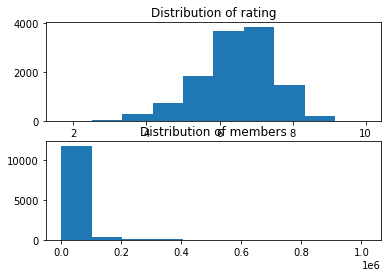

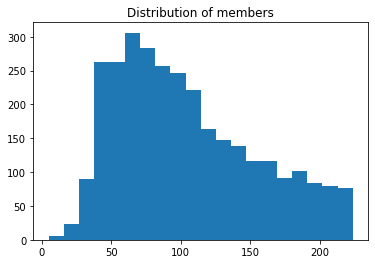

In [3]:
# explore data
## 1. anime dataset
anime.describe()
# plot distribution of rating and members with histogram
fig,ax = plt.subplots(2,1)
ax[0,].hist(x=anime['rating'])
ax[0,].set_title('Distribution of rating')

ax[1,].hist(x=anime['members'])
ax[1,].set_title('Distribution of members')
plt.show()
#explore the distribution of members column with the 25% smallest value

fig,ax = plt.subplots()

ax.hist(x=anime[anime['members']< 225]['members'],bins=20)
ax.set_title('Distribution of members')
plt.show()



In [5]:
## 2. rating dataset
ratingByUsers=rating.groupby('user_id').agg(user_count = ('rating', 'count'), rating_mean = ('rating','mean'), \
rating_min = ('rating','min'), rating_max = ('rating','max'))
print(ratingByUsers.describe())
#Will delete the users with less than 5 ratings

         user_count   rating_mean    rating_min    rating_max
count  73515.000000  73515.000000  73515.000000  73515.000000
mean     106.287656      6.647726      2.157750      9.271387
std      153.086558      2.947754      3.599271      2.489264
min        1.000000     -1.000000     -1.000000     -1.000000
25%       18.000000      6.472973     -1.000000     10.000000
50%       57.000000      7.678082     -1.000000     10.000000
75%      136.000000      8.377330      5.000000     10.000000
max    10227.000000     10.000000     10.000000     10.000000


In [6]:
# create dataset for clustering
## 1. delete users with less than 5 ratings
ratingByUsers = ratingByUsers[ratingByUsers['user_count'] >= 5].reset_index()
print(ratingByUsers.info())

ratingAbove5 = rating[rating['user_id'].isin(ratingByUsers['user_id'])]
print(ratingAbove5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66870 entries, 0 to 66869
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      66870 non-null  int64  
 1   user_count   66870 non-null  int64  
 2   rating_mean  66870 non-null  float64
 3   rating_min   66870 non-null  int64  
 4   rating_max   66870 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 2.6 MB
None
         user_id  anime_id  rating
0              1        20      -1
1              1        24      -1
2              1        79      -1
3              1       226      -1
4              1       241      -1
...          ...       ...     ...
7813730    73515     13659       8
7813731    73515     14345       7
7813732    73515     16512       7
7813733    73515     17187       9
7813734    73515     22145      10

[7798944 rows x 3 columns]


In [7]:
## 2. calculate mean ratings of each user
meanRating = ratingAbove5.groupby('user_id').mean('rating').reset_index().drop(['anime_id'], axis = 1)
ratingAbove5 = ratingAbove5.merge(meanRating, on = 'user_id', suffixes = ['_anime', '_mean'])
print(ratingAbove5)

         user_id  anime_id  rating_anime  rating_mean
0              1        20            -1    -0.712418
1              1        24            -1    -0.712418
2              1        79            -1    -0.712418
3              1       226            -1    -0.712418
4              1       241            -1    -0.712418
...          ...       ...           ...          ...
7798939    73515     13659             8     7.719388
7798940    73515     14345             7     7.719388
7798941    73515     16512             7     7.719388
7798942    73515     17187             9     7.719388
7798943    73515     22145            10     7.719388

[7798944 rows x 4 columns]


In [8]:
## 3. define a rating greater than the mean as like
ratingAbove5['like'] = np.where(ratingAbove5['rating_anime'] >= ratingAbove5['rating_mean'], 1, 0)
print(ratingAbove5['user_id'].nunique())

## 4. subset the animes each users like
likedAnime = ratingAbove5[ratingAbove5['like'] == 1].drop(['rating_anime', 'rating_mean', 'like'], axis = 1)
print(likedAnime)
print(likedAnime['user_id'].nunique())

66870
         user_id  anime_id
47             1      8074
81             1     11617
83             1     11757
101            1     15451
153            3        20
...          ...       ...
7798936    73515     13161
7798937    73515     13331
7798939    73515     13659
7798942    73515     17187
7798943    73515     22145

[4251881 rows x 2 columns]
66870


In [26]:
## 5. merge likedAnime with anime
mergedata = likedAnime.merge(anime,on='anime_id', how = 'left')
mergedataSmall = mergedata[mergedata['user_id'] <= 20000]
user_anime = pd.crosstab(mergedataSmall['user_id'], mergedataSmall['name'])
print(user_anime.head())


name     &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi  \
user_id                                                        
1                                                        0     
3                                                        0     
4                                                        0     
5                                                        0     
6                                                        0     

name     &quot;Bungaku Shoujo&quot; Memoire  &quot;Bungaku Shoujo&quot; Movie  \
user_id                                                                         
1                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   
5                                         0                                 0   
6                                         0                      

In [27]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-1.730628,-0.536593,0.434029,-0.316770,-0.136127,0.261024
1,0.024220,-1.277338,-0.915094,1.621481,-0.147975,-0.033538
2,0.011724,-0.321093,0.726996,0.679312,-0.405355,-0.287783
3,3.400594,-0.146632,-0.773881,0.911255,0.203539,2.386087
4,-0.789015,-0.167968,0.889830,-0.012202,0.488256,-0.198774


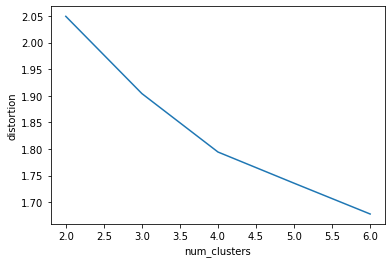

In [31]:
# K-means clustering
## 1. select the k = 4
from scipy.cluster.vq import kmeans, vq
distortions = []
num_clusters = range(2,7)

for i in num_clusters:
    centroids, distortion = kmeans(ps, i)
    distortions.append(distortion)
elbow_plot_data = pd.DataFrame({'num_clusters':num_clusters,\
'distortion': distortions}) 

sns.lineplot(x='num_clusters', y = 'distortion', \
             data = elbow_plot_data)
plt.show()

In [32]:
## 2. run clustering
cluster_centers, _ = kmeans (ps, 4)
user_anime['cluster'], _ = vq(ps, cluster_centers)
print(user_anime.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18204 entries, 1 to 20000
Columns: 7853 entries, &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi to cluster
dtypes: int32(1), int64(7852)
memory usage: 1.1 GB
None


In [54]:
# analyse each cluster
## 1. create dataset of each cluster
c0 = user_anime[user_anime['cluster'] == 0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster'] == 1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster'] == 2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster'] == 3].drop('cluster',axis=1).mean()


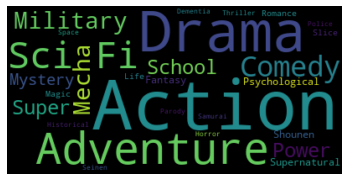

In [91]:
## 2. define a function to create word cloud

def word_cloud(df):
     text = ' '.join(df['genre'])
     wordcloud = WordCloud().generate(text)
     plt.imshow(wordcloud, interpolation='bilinear')
     plt.axis("off")
     plt.show()

                                     name  \
0         Code Geass: Hangyaku no Lelouch   
1                              Death Note   
2      Code Geass: Hangyaku no Lelouch R2   
3                     Fullmetal Alchemist   
4              Suzumiya Haruhi no Yuuutsu   
5           Sen to Chihiro no Kamikakushi   
6              Tengen Toppa Gurren Lagann   
7                 Neon Genesis Evangelion   
8                            Cowboy Bebop   
9        Fullmetal Alchemist: Brotherhood   
10                       Samurai Champloo   
11                          Mononoke Hime   
12                              Toradora!   
13                             Elfen Lied   
14  Darker than Black: Kuro no Keiyakusha   

                                                genre  
0   Action, Mecha, Military, School, Sci-Fi, Super...  
1   Mystery, Police, Psychological, Supernatural, ...  
2   Action, Drama, Mecha, Military, Sci-Fi, Super ...  
3   Action, Adventure, Comedy, Drama, Fantasy, Mag...  

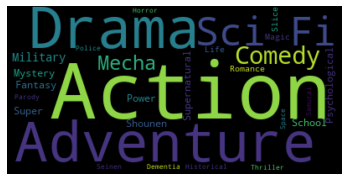

In [92]:
## Cluster 0 
listC0 = c0.sort_values(ascending=False)[0:15].to_frame().reset_index()

listC0Info = listC0.merge (anime, on = 'name', how = 'left')[['name', 'genre']]
print(listC0Info)

word_cloud(listC0Info)


                                                 name  \
0                                     No Game No Life   
1                                        Angel Beats!   
2                                  Shingeki no Kyojin   
3                                           Toradora!   
4                                         Steins;Gate   
5                                    Sword Art Online   
6                     Code Geass: Hangyaku no Lelouch   
7                                          Death Note   
8                                    Mirai Nikki (TV)   
9                    Fullmetal Alchemist: Brotherhood   
10                 Code Geass: Hangyaku no Lelouch R2   
11  Yahari Ore no Seishun Love Comedy wa Machigatt...   
12                                Hataraku Maou-sama!   
13                                           Noragami   
14                                     Bakemonogatari   

                                                genre  
0   Adventure, Comedy, Ecchi, F

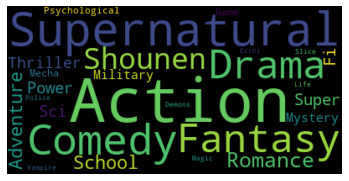

In [93]:
## Cluster 1 
listC1 = c1.sort_values(ascending=False)[0:15].to_frame().reset_index()

listC1Info = listC1.merge (anime, on = 'name', how = 'left')[['name', 'genre']]
print(listC1Info)

word_cloud(listC1Info)

                                  name  \
0                           Death Note   
1                   Shingeki no Kyojin   
2        Sen to Chihiro no Kamikakushi   
3                  Fullmetal Alchemist   
4                     Sword Art Online   
5      Code Geass: Hangyaku no Lelouch   
6     Fullmetal Alchemist: Brotherhood   
7               Ouran Koukou Host Club   
8                           Elfen Lied   
9                               Naruto   
10  Code Geass: Hangyaku no Lelouch R2   
11                 Howl no Ugoku Shiro   
12                        Angel Beats!   
13                       Mononoke Hime   
14                        Cowboy Bebop   

                                                genre  
0   Mystery, Police, Psychological, Supernatural, ...  
1        Action, Drama, Fantasy, Shounen, Super Power  
2                      Adventure, Drama, Supernatural  
3   Action, Adventure, Comedy, Drama, Fantasy, Mag...  
4           Action, Adventure, Fantasy, Game, R

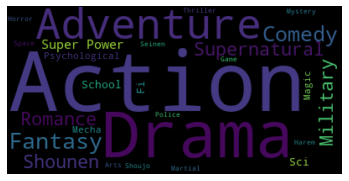

In [94]:
## Cluster 2 
listC2 = c2.sort_values(ascending=False)[0:15].to_frame().reset_index()

listC2Info = listC2.merge (anime, on = 'name', how = 'left')[['name', 'genre']]
print(listC2Info)

word_cloud(listC2Info)

                                                 name  \
0                                  Shingeki no Kyojin   
1                                          Death Note   
2                                    Sword Art Online   
3                                        Angel Beats!   
4                    Fullmetal Alchemist: Brotherhood   
5                     Code Geass: Hangyaku no Lelouch   
6                                         Steins;Gate   
7                                    Mirai Nikki (TV)   
8                                     No Game No Life   
9                  Code Geass: Hangyaku no Lelouch R2   
10                                          Toradora!   
11                                     Ao no Exorcist   
12                                        Tokyo Ghoul   
13  Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...   
14                               Clannad: After Story   

                                                genre  
0        Action, Drama, Fantasy

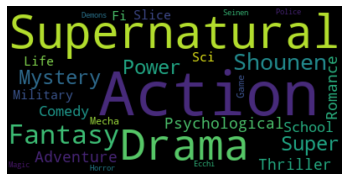

In [95]:
## Cluster 3 
listC3 = c3.sort_values(ascending=False)[0:15].to_frame().reset_index()

listC3Info = listC3.merge (anime, on = 'name', how = 'left')[['name', 'genre']]
print(listC3Info)

word_cloud(listC3Info)